# First CNN model

## Requirements

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from PIL import Image
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


## Preprocessing

In [2]:
def preprocess_images(X: pd.DataFrame, resize_size: tuple)-> np.ndarray:
    """
    INPUT
    X: the DataFrame from which we want to retrieve the image names in the 'Image_name' column

    resize_size: a tuple to which dimensions the images should be resized
    For example (100, 100) resizes the images to 100 x 100 pixels

    OUTPUT
    A numpy array of shape (number of images, pixel length, pixel height, color channels)
    """

    output = []

    for image_name in X['Image_name']:
        image_path = os.path.join("../raw_data/Images/", image_name)
        image = Image.open(image_path)
        image = image.resize(resize_size) # Resizing for speed purposes
        image_array = np.array(image)
        output.append(image_array)

    return np.array(output)

In [3]:
def get_data(cache_path: Path) -> pd.DataFrame:
    """Retrieve data from `cache_path`"""
    df = pd.read_csv(cache_path, delimiter=" ", index_col="Id")
    return df

In [4]:
X_train = get_data("../raw_data/train_x.csv")
y_train = get_data("../raw_data/train_y.csv")

X_test = get_data("../raw_data/test_x.csv")
y_test = get_data("../raw_data/test_y.csv")

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
images_folder = os.path.join(parent_directory, 'raw_data', 'Images')
images_filenames = os.listdir(images_folder)

In [5]:
print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((51300, 2), (51300, 2)) ((5700, 2), (5700, 2))


In [7]:
X_train_main = preprocess_images(X_train, (224,224))

In [8]:
X_test = preprocess_images(X_test, (224,224))

In [9]:
y_train = y_train['Genre_id']
y_test = y_test['Genre_id']

In [10]:
# Considering only 1/10th of the 50K+ images
reduction_factor = 10

# Choosing the random indices of small train set and small test set
idx_train =  np.random.choice(len(X_train_main), round(len(X_train_main)/reduction_factor), replace=False)
idx_test =  np.random.choice(len(X_test), round(len(X_test)/reduction_factor), replace=False)

# Collecting the two subsamples images_train_small and images_test_small from images_train and images_test
X_train_small = X_train_main[idx_train]
X_test_small = X_test[idx_test]

# and their corresponding labels
y_train_small = y_train[idx_train]
y_test_small = y_test[idx_test]

In [11]:
(X_train_main.shape, y_train.shape), (X_test.shape, y_test.shape)

(((51300, 224, 224, 3), (51300,)), ((5700, 224, 224, 3), (5700,)))

In [12]:
(X_train_small.shape, y_train_small.shape), (X_test_small.shape, y_test_small.shape)

(((5130, 224, 224, 3), (5130,)), ((570, 224, 224, 3), (570,)))

### Normalise train and test data - **add this to preprocessing**

Full datasets

In [13]:
# Define the batch size
batch_size = 100

# Create a list of arrays to process
arrays = [X_train_main, X_test]
lst = []
# Iterate over the arrays
for i, arr in enumerate(arrays):
    # Get the total number of images
    num_images = len(arr)

    # Calculate the total number of batches
    num_batches = int(np.ceil(num_images / batch_size))

    # Create an empty array to store the normalized images
    normalized_arr = np.empty_like(arr, dtype=np.float32)

    # Process images in batches
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_images)

        # Normalize the batch of images
        batch_images = arr[start_idx:end_idx] / 255.

        # Store the normalized batch in the result array
        normalized_arr[start_idx:end_idx] = batch_images

    # Assign the normalized array back to the original variable
    arr = normalized_arr
    lst.append(arr)

    # Print the shape of the array after normalization
    print(arr.shape)
    print(arr)

(51300, 224, 224, 3)
[[[[0.7882353  0.7647059  0.67058825]
   [0.7882353  0.7647059  0.67058825]
   [0.7921569  0.76862746 0.6745098 ]
   ...
   [0.76862746 0.74509805 0.65882355]
   [0.76862746 0.74509805 0.65882355]
   [0.76862746 0.74509805 0.65882355]]

  [[0.7882353  0.7647059  0.67058825]
   [0.7882353  0.7647059  0.67058825]
   [0.78039217 0.75686276 0.6627451 ]
   ...
   [0.76862746 0.74509805 0.65882355]
   [0.76862746 0.74509805 0.65882355]
   [0.76862746 0.74509805 0.65882355]]

  [[0.8117647  0.7882353  0.69411767]
   [0.8039216  0.78039217 0.6862745 ]
   [0.79607844 0.77254903 0.6784314 ]
   ...
   [0.76862746 0.74509805 0.65882355]
   [0.76862746 0.74509805 0.65882355]
   [0.76862746 0.74509805 0.65882355]]

  ...

  [[0.36078432 0.38039216 0.2901961 ]
   [0.3529412  0.37254903 0.28235295]
   [0.34509805 0.3647059  0.27450982]
   ...
   [0.36862746 0.3882353  0.29803923]
   [0.36862746 0.3882353  0.29803923]
   [0.36862746 0.3882353  0.29803923]]

  [[0.3529412  0.3725490

In [14]:
X_train = lst[0]

In [15]:
X_test = lst[1]

In [16]:
print(X_train.shape, X_test.shape)

(51300, 224, 224, 3) (5700, 224, 224, 3)


Do the same for Small Dataset

(X_train_small.shape, y_train_small.shape), (X_test_small.shape, y_test_small.shape)

In [17]:
# Define the batch size
batch_size = 100

# Create a list of arrays to process
arrays = [X_train_small, X_test_small]
lst = []
# Iterate over the arrays
for i, arr in enumerate(arrays):
    # Get the total number of images
    num_images = len(arr)

    # Calculate the total number of batches
    num_batches = int(np.ceil(num_images / batch_size))

    # Create an empty array to store the normalized images
    normalized_arr = np.empty_like(arr, dtype=np.float32)

    # Process images in batches
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_images)

        # Normalize the batch of images
        batch_images = arr[start_idx:end_idx] / 255.

        # Store the normalized batch in the result array
        normalized_arr[start_idx:end_idx] = batch_images

    # Assign the normalized array back to the original variable
    arr = normalized_arr
    lst.append(arr)

    # Print the shape of the array after normalization
    print(arr.shape)
    print(arr)

(5130, 224, 224, 3)
[[[[0.2        0.18431373 0.17254902]
   [0.2        0.18431373 0.17254902]
   [0.2        0.18431373 0.17254902]
   ...
   [0.18039216 0.1764706  0.16862746]
   [0.18039216 0.1764706  0.16862746]
   [0.18039216 0.1764706  0.16862746]]

  [[0.2        0.18431373 0.17254902]
   [0.2        0.18431373 0.17254902]
   [0.2        0.18431373 0.17254902]
   ...
   [0.18039216 0.1764706  0.16862746]
   [0.18039216 0.1764706  0.16862746]
   [0.18039216 0.1764706  0.16862746]]

  [[0.2        0.18431373 0.17254902]
   [0.2        0.18431373 0.17254902]
   [0.2        0.18431373 0.17254902]
   ...
   [0.18039216 0.1764706  0.16862746]
   [0.18039216 0.1764706  0.16862746]
   [0.18039216 0.1764706  0.16862746]]

  ...

  [[0.14509805 0.18039216 0.16078432]
   [0.14509805 0.18039216 0.16078432]
   [0.15294118 0.1764706  0.16078432]
   ...
   [0.16078432 0.16078432 0.16078432]
   [0.16470589 0.16470589 0.16470589]
   [0.16470589 0.16470589 0.16470589]]

  [[0.15294118 0.18039216

In [18]:
len(lst)

2

In [19]:
X_train_small = lst[0]

In [20]:
X_test_small = lst[1]

### One-Hot-Encode target y - **add this to preprocessing**

In [21]:
y_train

Id
0         1
1         4
2        10
3         9
4        26
         ..
51295    17
51296    17
51297    17
51298    17
51299    17
Name: Genre_id, Length: 51300, dtype: int64

In [22]:
len(np.unique(y_train))

30

In [23]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)

In [24]:
y_train_small_cat = to_categorical(y_train_small, num_classes=30)
y_test_small_cat = to_categorical(y_test_small, num_classes=30)

In [25]:
y_train_cat.shape, y_test_cat.shape, y_train_small_cat.shape, y_test_small_cat.shape

((51300, 30), (5700, 30), (5130, 30), (570, 30))

In [26]:
X_train.shape, y_train_cat.shape

((51300, 224, 224, 3), (51300, 30))

## Final datasets

In [27]:
(X_train.shape, y_train_cat.shape), (X_test.shape, y_test_cat.shape)

(((51300, 224, 224, 3), (51300, 30)), ((5700, 224, 224, 3), (5700, 30)))

In [28]:
(X_train_small.shape, y_train_small_cat.shape), (X_test_small.shape, y_test_small_cat.shape)

(((5130, 224, 224, 3), (5130, 30)), ((570, 224, 224, 3), (570, 30)))

In [29]:
#X_train_path = "../raw_data/train_x_prep.csv"
#num_samples, width, height, channels = X_train.shape
#X_train_2d = np.reshape(X_train, (num_samples, width * height * channels))
#df_X_train = pd.DataFrame(X_train_2d)
# PENDING TO SAVE ALL DATASETS AS CSVs
#df_X_train.to_csv(X_train_path, index=False)

In [29]:
file_path = '../raw_data/tmp_data/test_x_prep.npy'
np.save(file_path, X_test)

## CNN - dummy model

In [30]:
def initialize_model():
    model = models.Sequential()
    
    # Convolution 1 & MaxPooling
    model.add(layers.Conv2D(8, (4,4), input_shape=(224, 224, 3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Convolution 2 & MaxPooling
    model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Convolution 3 & MaxPooling
    model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Convolution 4 & MaxPooling
    model.add(layers.Conv2D(64, (2,2), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Flattening
    model.add(layers.Flatten())
    
    # Hidden Dense layer
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    
    ### Last layer - Classification Layer with 30 outputs corresponding to 30 digits
    model.add(layers.Dense(30, activation='softmax'))
    
    ## Model compilation
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [31]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 8)       392       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      2336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 25, 25, 64)        0

In [32]:
model = initialize_model()
es = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train_small, y_train_small_cat,
         validation_split = 0.2,
         epochs=50, 
         batch_size=32,
         verbose=1, 
         callbacks=[es])

Epoch 1/50
129/129 [==============================] - 31s 233ms/step - loss: 3.4021 - accuracy: 0.0307 - val_loss: 3.4011 - val_accuracy: 0.0205
Epoch 2/50
129/129 [==============================] - 31s 238ms/step - loss: 3.3995 - accuracy: 0.0346 - val_loss: 3.3972 - val_accuracy: 0.0361
Epoch 3/50
129/129 [==============================] - 28s 220ms/step - loss: 3.3901 - accuracy: 0.0400 - val_loss: 3.4036 - val_accuracy: 0.0419
Epoch 4/50
129/129 [==============================] - 26s 205ms/step - loss: 3.3439 - accuracy: 0.0631 - val_loss: 3.3936 - val_accuracy: 0.0517
Epoch 5/50
129/129 [==============================] - 26s 201ms/step - loss: 3.2254 - accuracy: 0.1021 - val_loss: 3.4352 - val_accuracy: 0.0585
Epoch 6/50
129/129 [==============================] - 27s 206ms/step - loss: 2.9870 - accuracy: 0.1659 - val_loss: 3.5638 - val_accuracy: 0.0682
Epoch 7/50
129/129 [==============================] - 28s 214ms/step - loss: 2.6145 - accuracy: 0.2702 - val_loss: 3.8180 - val_ac

In [33]:
model.evaluate(X_test_small, y_test_small_cat)[1]

18/18 [==============================] - 1s 48ms/step - loss: 3.3674 - accuracy: 0.0386


0.038596492260694504

10.8% accuracy in first model

## Improving the CNN

In [34]:
X_train.shape, X_train_small.shape, y_train_small.shape

((51300, 200, 200, 3), (5130, 200, 200, 3), (5130,))

In [36]:
def initialize_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3,3), input_shape=(224, 224, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (2,2), padding='same', strides=(1,1), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (2,2), padding='same', strides=(1,1), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(30, activation='softmax'))
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [37]:
model = initialize_model()

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_small, y_train_small_cat,
         validation_split = 0.2,
         epochs=50, 
         batch_size=32,
         verbose=1, 
         callbacks=[es])

Epoch 1/50
 67/129 [==============>...............] - ETA: 10s - loss: 3.4314 - accuracy: 0.0350

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

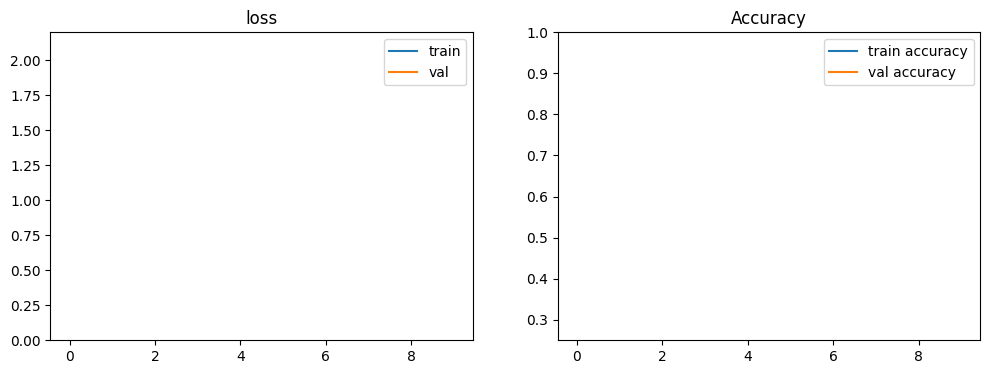

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(X_test_small, y_test_small_cat)[1]

179/179 [==============================] - 2s 13ms/step - loss: 3.1592 - accuracy: 0.1249


0.12491228431463242